In [1]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available


✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [2]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path_1 = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

if os.path.exists(model_path_1):
    state_dict = torch.load(model_path_1, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path_1}")
else:
    print(f"✗ Model not found: {model_path_1}")

# # 1.2. Load dữ liệu 
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu từ vnstock...")
# df_raw = provider.get_ohlcv_data('SSI', '2021-12-14', '2024-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2022')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

df_processed_train = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\train\\good_train_GAS.csv')
df_processed_train.rename(columns={'date': 'time'}, inplace=True)
df_processed_train['time'] = pd.to_datetime(df_processed_train['time']).dt.strftime('%d/%m/%Y')

df_processed_test = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_GAS.csv')
df_processed_test.rename(columns={'date': 'time'}, inplace=True)
df_processed_test['time'] = pd.to_datetime(df_processed_test['time']).dt.strftime('%d/%m/%Y')

# Ghép dữ liệu: train trước rồi đến test (theo thời gian) thay vì dùng toán tử '+'
df_processed = pd.concat([df_processed_train, df_processed_test], ignore_index=True)
# Đảm bảo thứ tự thời gian tăng dần nếu chưa chắc chắn
_df_time = pd.to_datetime(df_processed['time'], format='%d/%m/%Y')
df_processed = df_processed.assign(_time=_df_time).sort_values('_time').drop(columns=['_time']).reset_index(drop=True)
print(f"✓ Merged train+test: {df_processed.shape} (train={df_processed_train.shape}, test={df_processed_test.shape})")
print(f"  Time range: {df_processed['time'].iloc[0]} -> {df_processed['time'].iloc[-1]}")

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth
✓ Merged train+test: (2248, 10) (train=(1496, 10), test=(752, 10))
  Time range: 02/01/2013 -> 31/12/2021

Đang chạy simulation...
✓ Simulation hoàn tất: 2248 states, 2247 actions
  Total reward: 5030.21
  Final portfolio: $6030.21


In [3]:
# # 1.2. Load dữ liệu ACB
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu ACB từ vnstock...")
# df_raw = provider.get_ohlcv_data('ACB', '2012-12-14', '2022-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2013')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

# # 1.4. Khởi tạo MDP và chạy simulation
# mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

# def pi_deep(s, eps=0.0, greedy=True):
#     with torch.no_grad():
#         out_qsa = qsa(torch.Tensor(s).float()).squeeze()
#         action = out_qsa.argmax().item() - 5
#     return action

# # State ban đầu
# first_row = df_processed.iloc[0]
# state_init = [
#     float(first_row['close']),
#     mdp.balance_init,
#     0,
#     float(first_row['MACD']),
#     float(first_row['RSI']),
#     float(first_row['CCI']),
#     float(first_row['ADX'])
# ]

# # Chạy simulation
# print("\nĐang chạy simulation...")
# states, rewards, actions = mdp.simulate(
#     df_processed[1:].reset_index(drop=True), 
#     state_init, 
#     pi_deep, 
#     greedy=True, 
#     eps=0.0
# )

# print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
# print(f"  Total reward: {sum(rewards):.2f}")
# print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

In [4]:
# # 1.1. Load model SARSA
# qsa = Qsa(input_size=7, num_classes=11)
# model_path_1 = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

# if os.path.exists(model_path_1):
#     state_dict = torch.load(model_path_1, map_location=torch.device('cpu'))
#     qsa.load_state_dict(state_dict)
#     qsa.eval()
#     print(f"✓ Model loaded: {model_path_1}")
# else:
#     print(f"✗ Model not found: {model_path_1}")

In [5]:
# df_processed_1 = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_ACB.csv')


In [6]:
# # 1.4. Khởi tạo MDP và chạy simulation
# mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

# def pi_deep(s, eps=0.0, greedy=True):
#     with torch.no_grad():
#         out_qsa = qsa(torch.Tensor(s).float()).squeeze()
#         action = out_qsa.argmax().item() - 5
#     return action

# # State ban đầu
# first_row = df_processed_1.iloc[0]
# state_init = [
#     float(first_row['close']),
#     mdp.balance_init,
#     0,
#     float(first_row['MACD']),
#     float(first_row['RSI']),
#     float(first_row['CCI']),
#     float(first_row['ADX'])
# ]

# # Chạy simulation
# print("\nĐang chạy simulation...")
# states, rewards, actions = mdp.simulate(
#     df_processed_1[1:].reset_index(drop=True), 
#     state_init, 
#     pi_deep, 
#     greedy=True, 
#     eps=0.0
# )

# print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
# print(f"  Total reward: {sum(rewards):.2f}")
# print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

## SHAP cho states agent vừa mô phỏng
Mục tiêu: giải thích đóng góp của từng feature (giá, vốn, vị thế, MACD, RSI, CCI, ADX) lên Q-value của hành động mà agent đã chọn tại mỗi timestep. Chúng ta sử dụng KernelExplainer cho dữ liệu tabular và hàm dự đoán trả về Q-value của hành động đã thực thi.

In [7]:
# Chuẩn bị dữ liệu X và hàm dự đoán cho SHAP
import importlib
if importlib.util.find_spec('shap') is None:
    import sys, subprocess
    print('Đang cài đặt shap...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap
else:
    import shap

# Ma trận trạng thái từ mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Hàm dự đoán: trả về Q-value của hành động greedy (argmax) cho mỗi hàng
def predict_q_greedy(X_batch):
    X_t = torch.tensor(X_batch, dtype=torch.float32)
    with torch.no_grad():
        q = qsa(X_t)  # [N, 11]
        # Lấy Q-value theo hành động có Q lớn nhất cho từng hàng
        ai = torch.argmax(q, dim=1)  # [N]
        out = q.gather(dim=1, index=ai.view(-1,1)).squeeze(1)  # [N]
        return out.cpu().numpy().astype(np.float32)

print(f'X shape: {X.shape}')

X shape: (2248, 7)


In [8]:
# Tính SHAP values với KernelExplainer (có thể mất vài phút với dữ liệu lớn)
# Chọn background nhỏ để tăng tốc
rng = np.random.default_rng(42)
bg_idx = rng.choice(len(X), size=min(3000, len(X)), replace=False)
X_bg = X[bg_idx]

# Chọn sample để giải thích (ví dụ 300 bước gần nhất hoặc toàn bộ nếu ít hơn)
sample_len = len(X)
X_sample = X[-sample_len:]

explainer = shap.KernelExplainer(predict_q_greedy, X_bg)
shap_values = explainer.shap_values(X_sample, nsamples='auto')
print('✓ Đã tính xong SHAP values cho sample:', len(X_sample))

Using 2248 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2248 [00:00<?, ?it/s]

✓ Đã tính xong SHAP values cho sample: 2248


In [9]:
X

array([[   1.12    , 1000.      ,    0.      , ...,   65.65168 ,
         133.83838 ,   30.660578],
       [   1.13    ,  994.3944  ,    5.      , ...,   67.1719  ,
         122.897354,   31.450804],
       [   1.17    ,  988.7388  ,   10.      , ...,   72.42849 ,
         173.72217 ,   33.3064  ],
       ...,
       [  26.26    ,  497.4079  ,  208.      , ...,   37.575947,
         -81.08381 ,   34.03422 ],
       [  26.2     ,  497.4079  ,  208.      , ...,   37.04449 ,
         -71.99394 ,   33.370922],
       [  26.6     ,  497.4079  ,  208.      , ...,   42.847916,
         -26.768814,   32.302467]], dtype=float32)

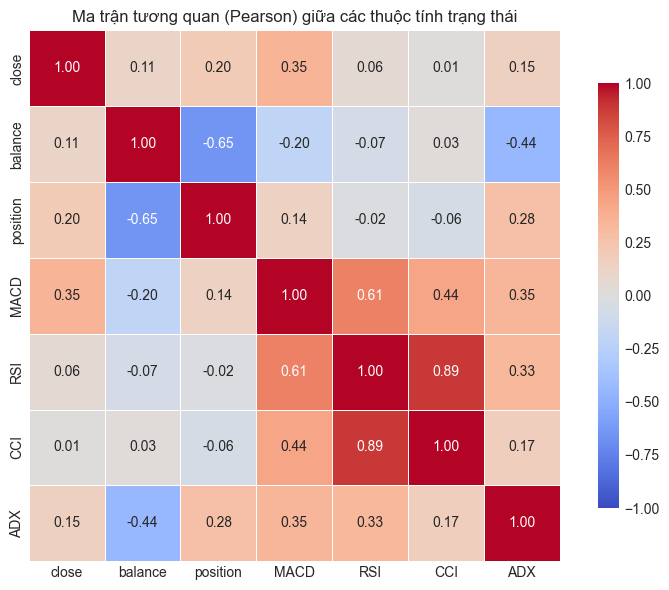

In [10]:
# Tính ma trận tương quan và vẽ heatmap
# Sử dụng dữ liệu states đã mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Tạo DataFrame để tính tương quan
X_df = pd.DataFrame(X, columns=feature_names)

# Loại bỏ các hàng có NaN (nếu còn)
X_df_clean = X_df.dropna()

# Tính ma trận tương quan Pearson
corr = X_df_clean.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
            fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái')
plt.tight_layout()
plt.show()

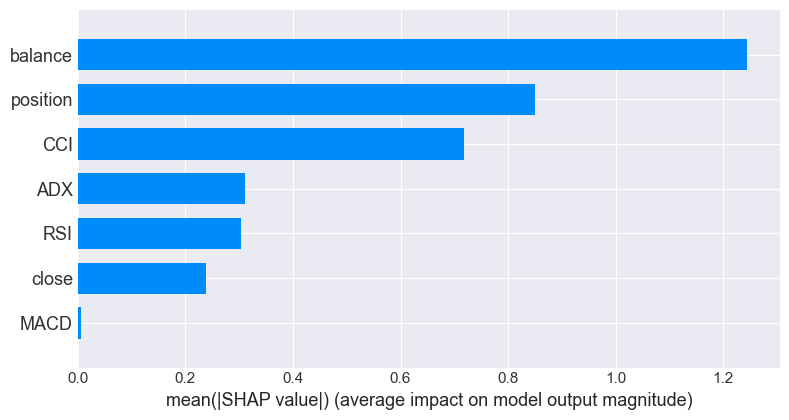

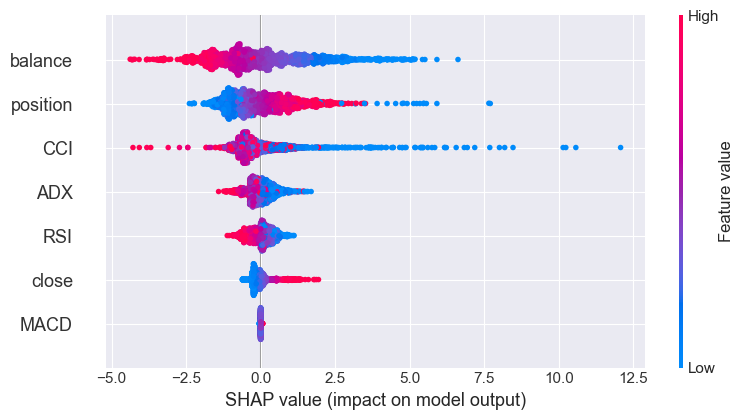

In [11]:
# Visualization: summary bar + beeswarm cho sample
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
# plt.title('SHAP Summary (Bar) - Q của hành động đã thực thi')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
# plt.title('SHAP Beeswarm - Phân phối đóng góp theo timestep')
plt.tight_layout()
plt.show()

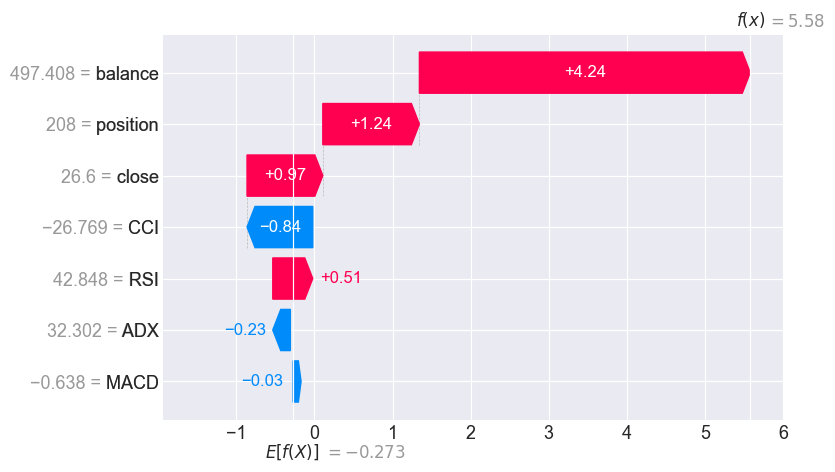

In [12]:
# Waterfall cho một timestep cụ thể (ví dụ timestep cuối cùng)
idx = -1  # phần tử cuối của sample
base_val = np.mean(predict_q_greedy(X_bg))
shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                       base_values=base_val,
                                       data=X_sample[idx],
                                       feature_names=feature_names))

In [13]:
from matplotlib.backends.backend_pdf import PdfPages


def save_analysis_to_pdf(X_df_clean, shap_values, X_sample, feature_names, base_val, output_path):
    """
    Lưu các biểu đồ phân tích (Heatmap, SHAP Bar, SHAP Beeswarm, SHAP Waterfall) vào 1 file PDF.
    
    Args:
        X_df_clean: DataFrame đã làm sạch để vẽ Heatmap.
        shap_values: Giá trị SHAP đã tính toán.
        X_sample: Dữ liệu mẫu dùng để tính SHAP.
        feature_names: Danh sách tên các đặc trưng.
        base_val: Giá trị nền (base value) cho Waterfall plot.
        output_path: Đường dẫn lưu file PDF (VD: 'reports/analysis_report.pdf').
    """
    print(f"Đang tạo file PDF tại: {output_path}...")
    
    # Kích thước chuẩn A4 (ngang hoặc dọc tùy chỉnh, ở đây dùng Landscape cho dễ nhìn SHAP)
    # A4 size in inches: 8.27 x 11.69. Landscape: 11.69 x 8.27
    A4_WIDTH = 11.69
    A4_HEIGHT = 8.27

    with PdfPages(output_path) as pdf:
        
        # --- TRANG 1: MA TRẬN TƯƠNG QUAN (HEATMAP) ---
        fig1 = plt.figure(figsize=(10, 8)) # Canh chỉnh cho vừa trang
        corr = X_df_clean.corr(method='pearson')
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
                    fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
        # plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig1)  # Lưu trang hiện tại
        plt.close(fig1)    # Giải phóng bộ nhớ

        # --- TRANG 2: SHAP SUMMARY (BAR PLOT) ---
        fig2 = plt.figure(figsize=(10, 6))
        # show=False để không hiển thị ngay mà lưu vào figure hiện tại
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                          plot_type='bar', show=False)
        plt.title('Mức độ quan trọng của đặc trưng (SHAP Bar)', fontsize=14)
        # bbox_inches='tight' cực quan trọng với SHAP để không bị cắt chữ
        plt.tight_layout()
        pdf.savefig(fig2, bbox_inches='tight') 
        plt.close(fig2)

        # --- TRANG 3: SHAP SUMMARY (BEESWARM PLOT) ---
        fig3 = plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        # plt.title('Phân phối tác động của đặc trưng (SHAP Beeswarm)', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig3, bbox_inches='tight')
        plt.close(fig3)

        # --- TRANG 4: SHAP WATERFALL (TIMESTEP CUỐI) ---
        # Waterfall của SHAP vẽ hơi khác, cần xử lý khéo
        fig4 = plt.figure(figsize=(10, 6))
        idx = -1
        
        # Waterfall plot vẽ trực tiếp lên current figure
        shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                              base_values=base_val,
                                              data=X_sample[idx],
                                              feature_names=feature_names),
                             show=False) # Quan trọng: show=False
        
        # Waterfall thường không có title mặc định, ta có thể add thêm nếu muốn
        # plt.title(f'Giải thích chi tiết cho mẫu cuối cùng (Index {idx})', fontsize=14)
        
        plt.tight_layout()
        pdf.savefig(fig4, bbox_inches='tight')
        plt.close(fig4)
        
    print("✓ Đã lưu thành công file PDF!")

In [14]:
import os
import re

# --- 1. SETUP ĐƯỜNG DẪN OUTPUT ---
output_dir = "D:\\NCKH\\SARSA_FinancialRL\\application\\results\\xai_analysis\\"
os.makedirs(output_dir, exist_ok=True)

# --- 2. PARSE TÊN THEO ĐÚNG FORMAT YÊU CẦU ---
# Định dạng: SHAP_Report_<agentStage>_SARSA_<dataStage>_<ticker>.pdf
# - agentStage: lấy từ tên file model (good/bad)
# - dataStage: lấy từ nguồn df_processed (good/bad)
# - ticker: tên cổ phiếu dùng để lấy dữ liệu (từ nguồn df_processed)

# 2.1 Parse agentStage từ model_path_1
file_name_raw = os.path.splitext(os.path.basename(model_path_1))[0]
parts = file_name_raw.split('_')
# ví dụ: 'sarsa_good_acb' -> ['sarsa','good','acb']
agentStage = (parts[1] if len(parts) > 1 else 'unknown').upper()

# 2.2 Parse dataStage & ticker từ các đường dẫn data đã dùng để tạo df_processed
# Ưu tiên biến df_processed_train / df_processed_test nếu tồn tại tên file
_data_paths = []
try:
    _data_paths.append('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\train\\good_train_GAS.csv')
    _data_paths.append('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_GAS.csv')
except Exception:
    pass

# Heuristic: tìm "good"/"bad" trong path để xác định dataStage
dataStage = 'UNKNOWN'
ticker = 'UNKNOWN'
for p in _data_paths:
    base = os.path.basename(p).lower()
    if 'good' in base:
        dataStage = 'GOOD'
    elif 'bad' in base:
        dataStage = 'BAD'
    # cố gắng bắt ticker bằng regex: *_<TICKER>.csv
    m = re.search(r"_([A-Za-z]{2,5})\.csv$", base)
    if m:
        ticker = m.group(1).upper()

# Nếu vẫn UNKNOWN ticker, thử suy từ df_processed columns (không bắt buộc)
if ticker == 'UNKNOWN':
    # nếu có biến df_processed và có cột 'symbol' thì lấy unique đầu tiên
    try:
        if 'symbol' in df_processed.columns:
            ticker = str(df_processed['symbol'].iloc[0]).upper()
    except Exception:
        pass

# --- 3. TẠO TÊN FILE THEO ĐÚNG QUY ƯỚC ---
pdf_filename = f"SHAP_Report_{agentStage}_SARSA_{dataStage}_{ticker}.pdf"
full_output_path = os.path.join(output_dir, pdf_filename)

print(f"🤖 Nhận diện: agentStage={agentStage}, dataStage={dataStage}, ticker={ticker}")
print(f"📄 Sẽ lưu PDF: {pdf_filename}")

# --- 4. GỌI HÀM LƯU PDF ---
try:
    save_analysis_to_pdf(X_df_clean, shap_values, X_sample, feature_names, base_val, full_output_path)
    print(f"✓ Đã lưu xong tại: {full_output_path}")
except PermissionError:
    print("❌ LỖI: File đang mở, vui lòng đóng file PDF lại!")

🤖 Nhận diện: agentStage=BAD, dataStage=GOOD, ticker=GAS
📄 Sẽ lưu PDF: SHAP_Report_BAD_SARSA_GOOD_GAS.pdf
Đang tạo file PDF tại: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\SHAP_Report_BAD_SARSA_GOOD_GAS.pdf...
✓ Đã lưu thành công file PDF!
✓ Đã lưu xong tại: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\SHAP_Report_BAD_SARSA_GOOD_GAS.pdf
